# Real or Not? NLP with Disaster Tweets (Kaggle Competition)

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("", width=600)

[Link to the GitHub repository](https://github.com/XaviJunior/SBB)

[Link to the YouTube video]()

## Contributions

* **Xavier AEBY**: experiments with Doc2Vec, video
* **Tarik BACHA**: experiments with neural networks, model explanation, EDA
* **Tanguy BERGUERAND**: cleaning, experiments with various models
* **Frederic SPYCHER**: cleaning, notebook writing/proofreading

## Introduction

For our second group project, we were asked to join the [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) Kaggle competition. This challenge consists of training a machine learning model that can predict, using **natural language processing** (NLP), whether tweets about **disasters** are genuine.

From the Kaggle website:

_Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But, it’s not always clear whether a person’s words are actually announcing a disaster._

Therefore, the **incentive** for building such a model is to bolster the monitoring efforts of the aforementioned organizations and help them to identify actual threats more quickly and with more accuracy.

## Setting things up

For NLP operations like tokenization, we turned to the powerful Python library **spaCy**. It comes with a pretrained model for English (`en_core_web_sm`).

As for machine learning models, we mostly used the toolkit offered by the **scikit-learn** library. Experiments with neural networks were done with **Keras/TensorFlow**.

If the environment does not contain spaCy, Keras and TensorFlow already, they can be installed by uncommenting and calling the following commands.

In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

# !pip install keras
# !pip install --upgrade tensorflow==1.14.0

# !pip install wordcloud

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import NuSVC

from wordcloud import WordCloud

RSEED = 42

In order to get reproducible and comparable results, we arbitrarily chose a **random seed** to be used as a parameter for the train/test split and models.

## The data

The data provided by Kaggle contains more than **10,000 tweets**, for 70% of which we are given the `target` class, i.e. whether they are true (1) or false (0). Each observation from the training data is composed of an `id` and the `text` of the tweet.

For most records, a `keyword` is given. There are a total of 221 unique keywords, all of which somehow pertain to accidents and disasters. They are assigned to tweets of both classes (e.g. the keyword "accident" is found in 24 tweets of class 1 and 11 tweets of class 0). They were most likely added to mimic Twitter monitoring systems, which are usually based on keyword extraction. However, the point of building a NLP model is to replace those systems, which have proven to be unreliable. Therefore, we do not think it wise to take this feature into account for our models. 

Although the tweet's `location` is sometimes available, it is however missing in a large quantity of tweets. Moreover, the values found in this feature are very messy, probably due to the fact that they are user-generated (e.g. Birmingham; Est. September 2012 - Bristol; AFRICA; Philadelphia, PA; TN; #NewcastleuponTyne #UK; etc.). As a result, we also disregard the location information.

### Training dataset

The training dataset contains 179 **duplicated tweets**. They are removed in order to avoid overfitting.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/XaviJunior/SBB/master/project_2/Data/train.csv", encoding="utf-8")
df = df.drop_duplicates(subset="text", keep="first")
df.reset_index(drop=True, inplace=True)

print("Classified observations:", df.shape[0])
df.head(3)

Classified observations: 7503


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


### Testing dataset

In [3]:
df_test = pd.read_csv("https://raw.githubusercontent.com/XaviJunior/SBB/master/project_2/Data/test.csv", encoding="utf-8")

print("Unclassified observations:", df_test.shape[0])
df_test.head(3)

Unclassified observations: 3263


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


## Cleaning

Text classification often comes with a host of cleaning needs, and this Twitter dataset is no different. In fact, when it comes to tweets, cleaning is extra tricky because of the presence of the strange character strings that are usernames and hashtags, as well as the use 

elongated words (function found at From https://github.com/ugis22/analysing_twitter/): thought it would be a good idea but consistently give slightly lower scores

Removing noise like hyperlinks, truncated tweets,

Weird encoding

remove point in initials

remove RT --> no effect
Removing user names @, but one should be aware that some didn't have the @

converting HTML codes

while inspecting the dataset, we also came across some spelling mistakes such as Norf. Even though it was not systematic, we corrected the few we found.

keeping only alphanumerical characters (which took care of pound sign in hashtags) and removing tokens containing only numbers

In [17]:
from notebook_functions import clean

df, df_test = clean(df, df_test, 
                    args=(True, True, True, True, True),  # remove/replace: numbers, users, RT, elongated words, punctuation
                    export=True)

## Exploratory data analysis

The training dataset is **slightly unbalanced**, with a base rate of 57.4% for non-disaster tweets.

Text(0, 0.5, '')

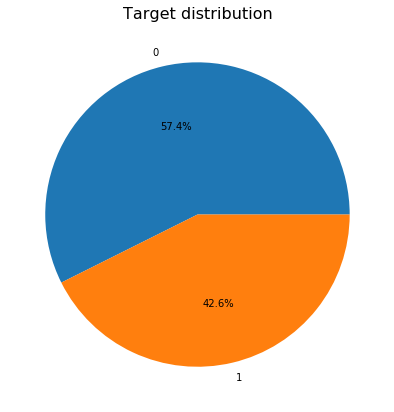

In [10]:
df_target = df.groupby(["target"])["id"].nunique()
ax = df_target.plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("Target distribution", size=16)
ax.set_ylabel("")

This word cloud as well as the table below help us to visualize the **most recurring words and expressions** in disaster tweets.

It is also interesting to note that some tokens such as "suicide bomber", "Northern California" and "California wilfdire" seem to be clear indicators of disaster. This leads us to think that it might be worthwhile to include 2-gram tokens in the vectorization.

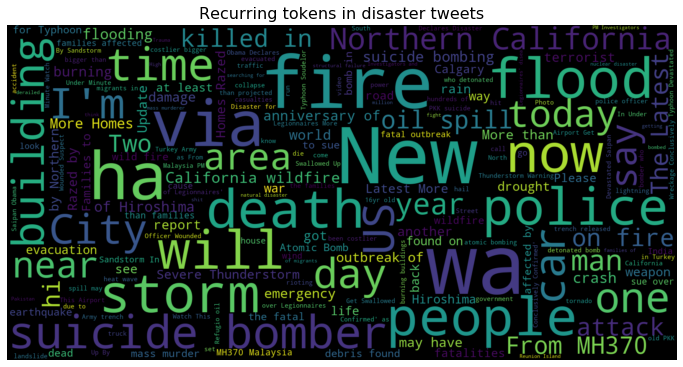

In [11]:
disaster_tweets = df[df["target"]==1]["text"]

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(disaster_tweets.str.cat(sep=" "))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Recurring tokens in disaster tweets", size=16)
plt.show()

In [6]:
from notebook_functions import token_counter

df_tokens = token_counter(df, ngram_range=(2,2))
df_tokens.sort_values(by="TOTAL", ascending=False).iloc[:10]

,Nothing,Disaster,TOTAL
suicide bomber,0,54,54
burning buildings,20,31,51
liked video,34,7,41
northern california,0,41,41
cross body,39,1,40
oil spill,1,38,39
suicide bombing,1,34,35
california wildfire,0,34,34
looks like,21,12,33
natural disaster,11,20,31


## Tokenization and vectorization

In order to get a representation that machine learning algorithms can work with, tweets first need to be **vectorized**. This results in a bag-of-words matrix containing either token counts or TF-IDF values for each tweet.

In order to make it more convenient to experiment with models, we created a custom function allowing to quickly switch between these two types of representation, as well as to specify the number of grams and tokens we want to exclude (post-cleaning).

In [18]:
from notebook_functions import create_vectorizer

vectorizer = create_vectorizer(mode="count",  # "count" or "tfidf"
                               ngram_range=(1,1), 
                               remove=[])

## Training models

In [19]:
X = vectorizer.fit_transform(df["text"].values.tolist())
y = df["target"].values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

X_train

<6002x11921 sparse matrix of type '<class 'numpy.int64'>'
	with 46141 stored elements in Compressed Sparse Row format>

In [20]:
# print(vectorizer.get_feature_names())

In [21]:
clf = NuSVC(nu=0.4, gamma=0.1, random_state=RSEED)
clf.fit(X_train, y_train)
f1_score(y_test, clf.predict(X_test))

0.7439446366782007

In [22]:
for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    clf = BernoulliNB(alpha=a, fit_prior=False)
    clf.fit(X_train, y_train)
    print(a, f1_score(y_test, clf.predict(X_test)))

0.1 0.7379421221864951
0.2 0.7412814274128142
0.3 0.748768472906404
0.4 0.7462437395659433
0.5 0.7396798652064027
0.6 0.7399829497016198
0.7 0.7407407407407407
0.8 0.7400346620450606
0.9 0.7377622377622378


In [9]:
clf = LogisticRegressionCV(solver="lbfgs", cv=5, max_iter=2000, random_state=RSEED)
clf.fit(X_train, y_train)
f1_score(y_test, clf.predict(X_test))

0.7252368647717485

### General process

For our **first attempts** at building a good model, we went back to algorithms previously seen in the Data Mining & Machine Learning and Big-Scale Analytics courses (without tweaking hyperparameters too much) in order to compare how they each generally perform with this particular dataset. The models that we tested were:

* Random forest
* XGBoost
* Logistic regression (with cross-validation)
* Support vector machine: SVC, NuSVC, SGDClassifier
* Neural network

As the first two were consistently giving us lower results, we excluded them from later tests.

The **second test phase** consisted of trying various cleaning and vectorization strategies. Here, we observed how keeping or removing certains tokens affected the mo

In the **last test phase**, we adjusted the hyperparameters for the best-performing models.

For model evaluation, we used the F1-score, since it is the same metric as the one used by Kaggle to evaluate each submission.

### Results

#### Impact of cleaning

Our early assumptions were that the cleaning strategy would have the highest impact on the model's quality. Some cleaning operations, such as the removal of hyperlinks, indeed proved to be a good choice. For others, we were not sure whether they would help or not.

Take the example of the "RT" keyword. One might argue that there are more retweets in case of a disaster, but this is hard to prove. Another one is punctuation. Maybe the presence of smileys like :( or :) can be an indicator of whether a tweet informs us about an actual catastrophe or not.

That is why we did systematic testing playing with these cleaning parameters. The results are shown in the table below.

In [193]:
url = "https://github.com/XaviJunior/SBB/blob/master/project_2/Data/cleaning_tests.xlsx?raw=true"
results = pd.read_excel(url, sheet_name=None)
results["cleaning_tests"].loc[:,["remove_numbers", "remove_users", "remove_rt", "remove_elongated", "remove_punctuation", "bow", "model", "score"]].fillna("-")

,remove_numbers,remove_users,remove_rt,remove_elongated,remove_punctuation,bow,model,score
0,False,False,False,False,False,tfidf,NuSVC,0.728086
1,False,False,True,False,False,tfidf,NuSVC,0.728086
2,False,True,True,False,False,tfidf,NuSVC,0.732095
3,True,True,True,False,False,tfidf,NuSVC,0.729537
4,True,True,True,False,True,tfidf,NuSVC,0.735816
5,True,True,True,True,True,tfidf,NuSVC,0.732444
6,False,False,False,False,False,count,NuSVC,0.735733
7,False,False,True,False,False,count,NuSVC,0.732865
8,False,True,True,False,False,count,NuSVC,0.729825
9,True,True,True,False,False,count,NuSVC,0.732568


To make sure the effects of cleaning were not tied to a specific model or type of vectorization, we ran these tests on 3 different models: NuSVC, LogisticRegressionCV and BernoulliNB, using both the TF-IDF and count representations.

In this table, we notice that:

* The overall difference in accuracy that these cleaning parameters add is very small (no more than 1%).
* There is no clear trend which is valid across all models and all vectorization types.
* The logistic regression consistently performs worse.
* with bernoulli, it doesn't matter whether you use tf-idf or count vectorization.

Still, some interesting observations can be made:

* The removal of the "RT" keyword mostly has no effect.
* Replacing elongated words has mostly a positive effect, except in the case of NuSVC-TF-IDF.
* Except for Bernoulli, removing punctuation has a positive effect.
* Removing users is positive, except in the cast of NuSVC-count


* In TF-IDF, removing numbers decreases accuracy.
* In Bernoulli, removing non alphanumeric characters decreases accuracy.


* The largest marginal increase in accuracy comes with the removal of usernames and the removal of punctuation.
* Removing numbers has a negative impact on the accuracy.
The best score (73.59%) was achieved with NuSVC-count and applying all optional cleaning operations. The funny thing is that the score is virtually the same as applying none of these operations. This leads us to question seriously whether any of these cleaning tests can be trusted. But at least it gives us an idea of what cleaning parameters work best for each model-vectorization combinations, which is going to help in the next step.

Knowing this, we are comfortable in the fact that our cleaning strategy was effective. However, judging by the general level of accuracy of our models, we are confident we are missing some cleaning steps which would help improve our models. One such step could be the separation of hashtags into distinct words.

#### Adjusting hyperparameters

Vectorizaton: accuracy decreases as n-grams increase

Didn't keep LogReg because not performing as good.
Several svm offered by sklearn (SVC, SGDClassifier, NuSVC), kept nuSVC because consistently giving better scores.

NuSVC :
* rbf default kernel performs best
* count: best = gamma 0.1, nu peak at 0.4 --> 0.7448275862068966
* tdidf: gamma depends on nu value. 0.5 0.3 0.7406113537117904

Bernoulli:
* better not to fit to prior, binarize has no effect
* depends on cleaining, 0.3-05, peak at alpha=0.4 0.7502131287297528
* near-instant computation time

#### Using a more complex model: the neural network

## Exporting predictions

To send our submissions for the Kaggle competition, we compute predictions for a set of tweets provided by the website and send them in a CSV file containing the tweet `id` and the predicted `target` 

In [169]:
clf.fit(X, y)
to_predict = vectorizer.transform(df_test["text"].values.tolist())
df_test["target"] = clf.predict(to_predict)

df_test[["id", "target"]].to_csv("UNIL_SBB_FSP.csv", index=False)